In [1]:
from tqdm import tqdm
import torch
from torch import nn
from torch.nn import functional as F
from torch import pi
import matplotlib.pyplot as plt
import scipy

In [2]:
n_samples = 1_000
batch_size = 128

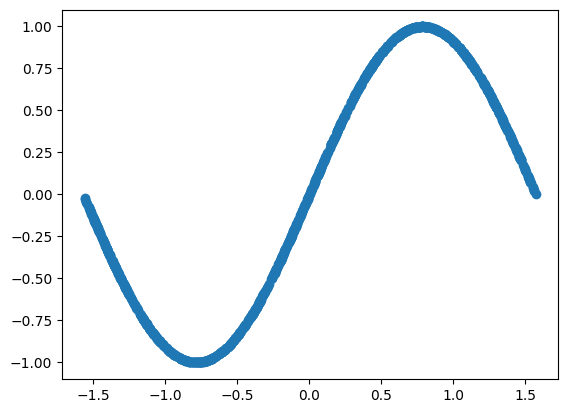

In [3]:
x = torch.rand((n_samples)) * pi - pi / 2
y = torch.sin(x * 2)

x0 = torch.cat([x.reshape(-1, 1), y.reshape(-1, 1)], dim=1)

plt.scatter(x0[:, 0].flatten(), x0[:, 1].flatten())

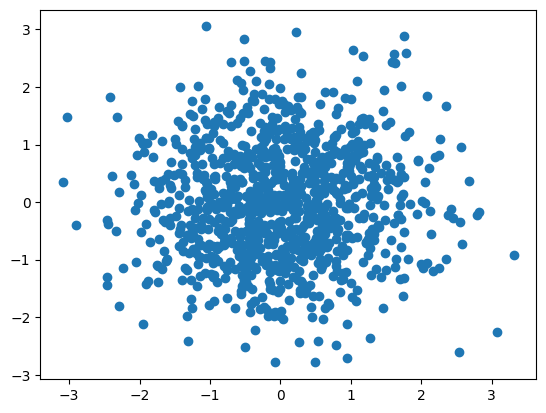

In [4]:
xT = torch.randn((n_samples, 2))
plt.scatter(xT[:, 0].flatten(), xT[:, 1].flatten())

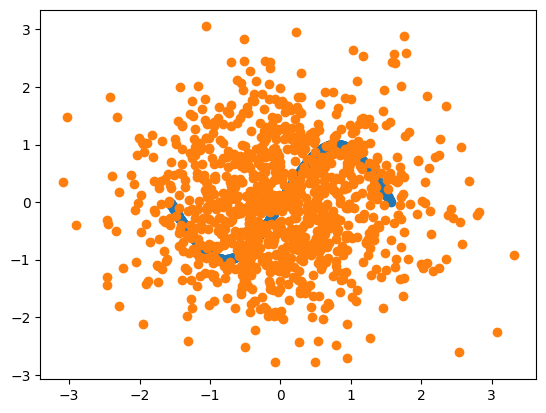

In [5]:
plt.scatter(x0[:, 0].flatten(), x0[:, 1].flatten())
plt.scatter(xT[:, 0].flatten(), xT[:, 1].flatten())

In [6]:
class DiffusionForcingLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=32, num_layers=1): 
        super().__init__()

        self.input_layer = nn.Linear(input_size, hidden_size)
        self.t_emb = nn.Linear(1, hidden_size)
        self.act1 = torch.nn.GELU()
        self.middle_layer1 = nn.Linear(hidden_size, hidden_size)

        self.rnn = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, bias=True, batch_first=True)

        self.act2 = torch.nn.GELU()
        self.output_layer = nn.Linear(hidden_size, input_size)

    def forward(self, x, t):
        t_emb = self.t_emb(t)

        x = self.input_layer(x) + t_emb
        x = self.act1(x)

        x = self.middle_layer1(x) + t_emb

        x, (h, c) = self.rnn(x)

        x = x + t_emb
        x = self.act2(x)
        x = self.output_layer(x)

        return x

In [7]:
model = DiffusionForcingLSTM(num_layers=2)

optimizer = torch.optim.AdamW(
    model.parameters(),
    3e-4,
)

loss_function = torch.nn.MSELoss()

# Train

In [8]:
n_steps = 10_000

losses = []

model.train()
for i in tqdm(range(n_steps)):
    x0_batch = x0[torch.sort(torch.randint(0, n_samples, (batch_size,)))[0]]
    xT_batch = torch.randn_like(x0_batch)
    
    t = torch.rand(batch_size, 1)

    xt = t * x0_batch + (1 - t) * xT_batch
    target = x0_batch - xT_batch

    output = model(xt.unsqueeze(dim=0), t)

    loss = loss_function(output, target)

    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|                                                                                                                                                 | 0/10000 [00:00<?, ?it/s]/Users/levnovitskiy/PycharmProjects/flow-matching-experiments/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([128, 2])) that is different to the input size (torch.Size([1, 128, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:32<00:00, 108.57it/s]


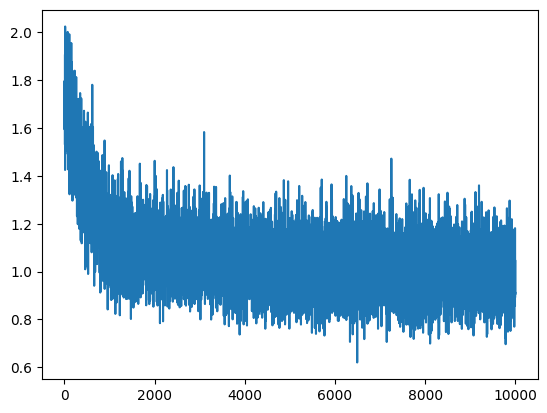

In [9]:
plt.plot(list(range(n_steps)), losses)

# Inference

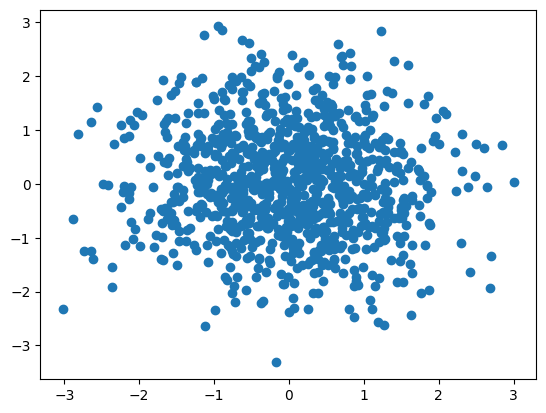

In [25]:
xT = torch.randn((n_samples, 2))
xT[:, 0] = torch.sort(xT[:, 0])[0]

plt.scatter(xT[:, 0].flatten(), xT[:, 1].flatten())

In [26]:
x_ts = [torch.clone(xT)]

t = torch.zeros((n_samples, 1))

window_size = 64
h = 1 / window_size

model.eval()
for i in tqdm(range(1, n_samples + window_size)):
    left = max(0, i - window_size)
    right = min(n_samples, i)
    
    xT_window = xT[left:right]
    t_window = t[left:right]

    with torch.no_grad():
        pred = model(xT_window, t_window)
    
    xT[left:right] = xT_window + h * pred 
    t[left:right] = t_window + h

    if i % (n_samples / 100) == 0:
        x_ts.append(torch.clone(xT))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:00<00:00, 1534.51it/s]


In [27]:
x_gen = torch.clone(xT)

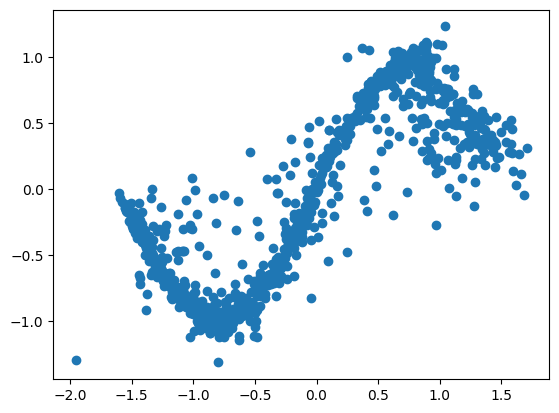

In [28]:
plt.scatter(xT[:, 0].flatten(), xT[:, 1].flatten())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 81.45it/s]


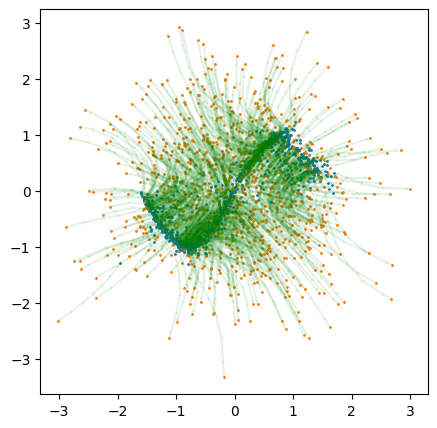

In [29]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_gen[:, 0], x_gen[:, 1], s=1)
plt.scatter(x_ts[0][:, 0], x_ts[0][:, 1], s=1)

step = 1

for sample_i in tqdm(range(n_samples)):
    for t in range(0, len(x_ts) - step - 1, step):
        plt.plot(
            [x_ts[t][sample_i, 0].item(), x_ts[t + step][sample_i, 0].item()], 
            [x_ts[t][sample_i, 1].item(), x_ts[t + step][sample_i, 1].item()], 
            c="Green",
            alpha=0.1
        )
        
plt.show()

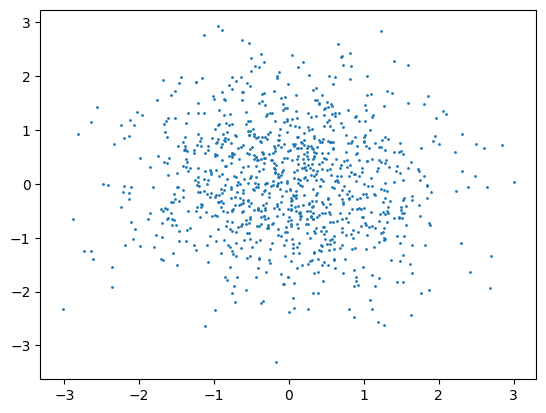

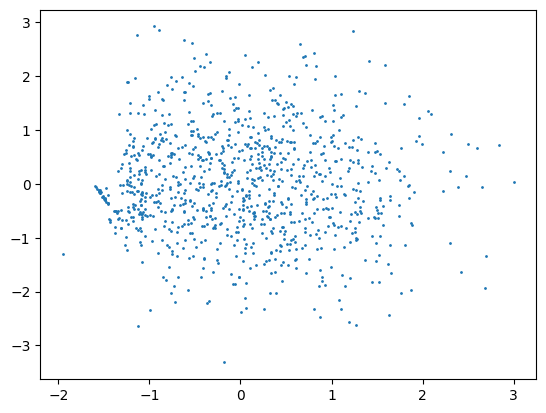

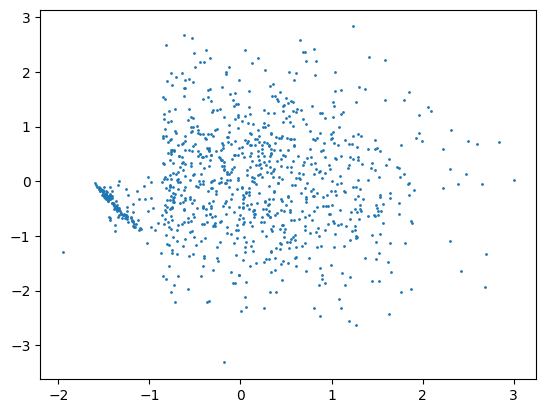

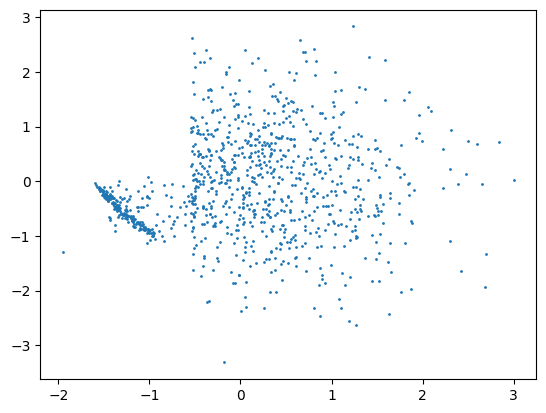

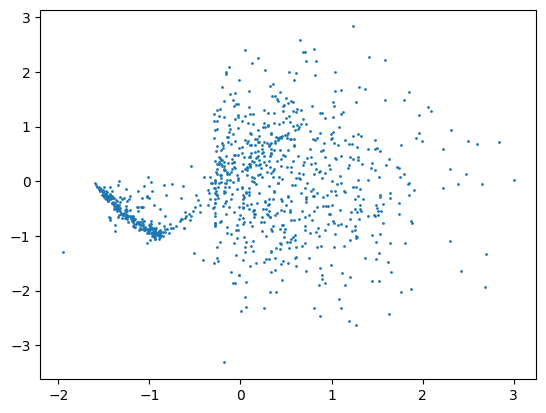

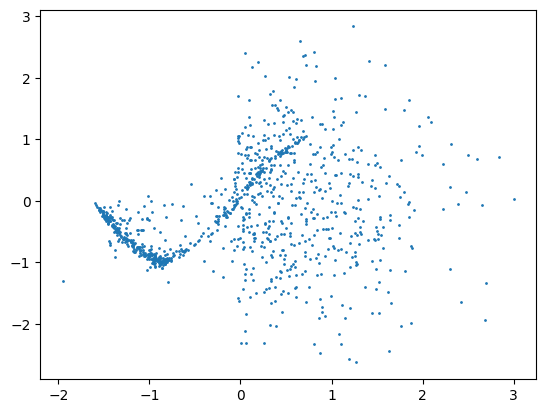

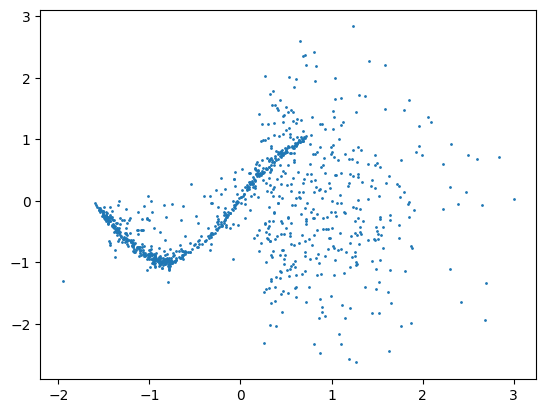

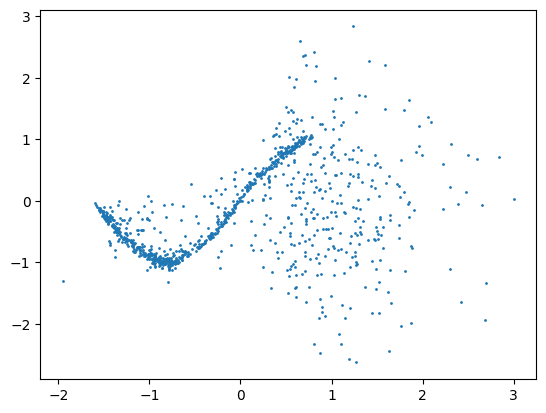

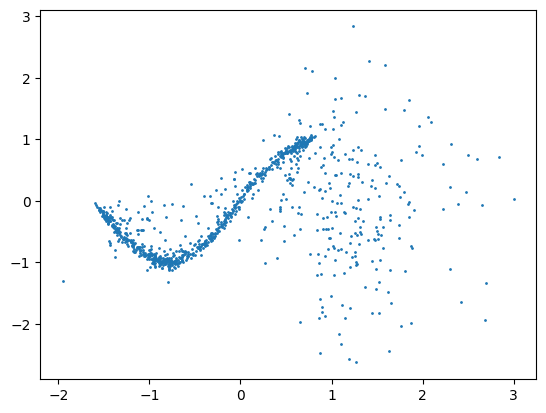

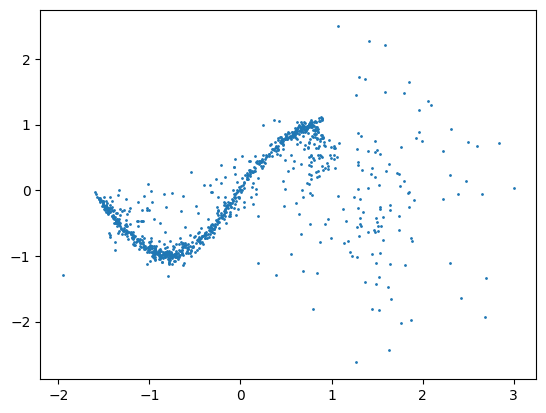

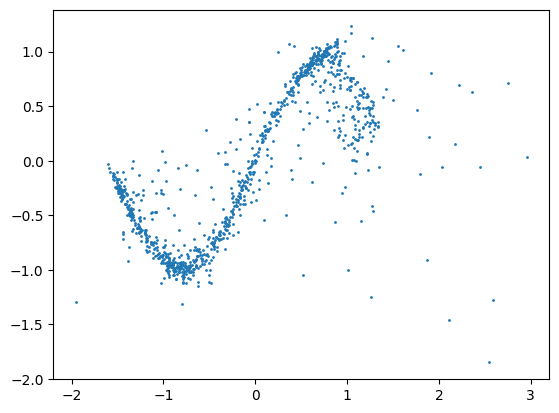

In [31]:
for i in range(len(x_ts)):
    if i % 10 == 0 or i == len(x_ts):
        plt.scatter(x_ts[i][:, 0], x_ts[i][:, 1], s=1)
        plt.show()